In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import viz


from tqdm import tqdm
from os import path

colors = viz.color_palette()
cnames_lin = 'green,blue,yellow,purple,red'.split(',')
lin_colors = [colors[c] for c in cnames_lin]

plt.style.use('style.mpl')

# Calculates contingency tables and plots them

Various modes of plotting, e.g. heatmap and bar plot. 

TODO: look for matches in the culture collections. We already know of one. 
https://gcm.wdcm.org/search

In [ ]:
summary_df = pd.read_csv('../output/annotree/chemoauto_summary_annotree.csv')
species_results_df = pd.read_csv('../output/annotree/annotree_files/bac120_taxonomy_r95.csv')
genome_metadata = pd.read_csv('../output/annotree/annotree_files/bac120_metadata_r95.csv', low_memory=False)


species_results_df['genome_id'] = species_results_df['gtdbId'].str[3:]
species_results_df['gtdb_order'] = species_results_df['gtdb_order'].str[3:]
genome_metadata['genome_id'] = genome_metadata['accession'].str[3:]


merged = pd.merge(summary_df, genome_metadata, on='genome_id')
summary_annot_df = pd.merge(merged, species_results_df, on='genome_id')
summary_annot_df.genome_id.unique().size

summary_annot_df.to_csv('../output/annotree/chemoauto_summary_annot.csv', index=False)

Index(['genome_id', 'rubisco', 'sbpase', 'fdh', 'h2ase', 'meoh', 'n2ase',
       'bmc', 'csos2', 'knallgas', 'alpha_csome', 'csome', 'cbb',
       'rubisco_csome', 'rubisco_csome_n2ase', 'rubisco_csome_fdh',
       'rubisco_csome_h2ase', 'rubisco_csome_fdh_h2ase', 'gtdbId',
       'gtdb_domain', 'gtdb_phylum', 'gtdb_class', 'gtdb_order', 'gtdb_family',
       'gtdb_genus', 'gtdb_species'],
      dtype='object')

In [ ]:
genome_hits = summary_annot_df[['genome_id','CBB_csome_fdh', 'CBB_csome_h2ase', 'CBB_csome_fdh_h2ase','CBB_csome','gtdb_domain', 'gtdb_phylum', 'gtdb_class', 'gtdb_order', 'gtdb_genus', 'gtdb_species','gc_percentage','genome_size','checkm_completeness']]
#genome_hits = summary_annot_df[['genome_id','rubisco_csome','rubisco_csome_fdh', 'rubisco_csome_h2ase', 'rubisco_csome_fdh_h2ase','gtdb_domain', 'gtdb_phylum', 'gtdb_class', 'gtdb_order', 'gtdb_genus', 'gtdb_species']]

genome_hits = genome_hits [~(genome_hits[['CBB_csome_fdh', 'CBB_csome_h2ase', 'CBB_csome_fdh_h2ase']] == False).all(axis=1)]
genome_hits = genome_hits.sort_values(by=['CBB_csome_fdh_h2ase', 'CBB_csome_fdh'], ascending=[False, False])

len(genome_hits)

In [ ]:
order_counts = genome_hits.groupby('gtdb_order').size().sort_values(ascending=False)
my_orders = order_counts.head(10).index
for_plotting = genome_hits[genome_hits.gtdb_order.isin(my_orders)]
for_plotting.head()

print(my_orders)

,genome_id,rubisco,sbpase,fdh,h2ase,meoh,n2ase,bmc,csos2,knallgas,...,rubisco_csome_h2ase,rubisco_csome_fdh_h2ase,gtdbId,gtdb_domain,gtdb_phylum,gtdb_class,gtdb_order,gtdb_family,gtdb_genus,gtdb_species
5,GCA_000153345.1,False,False,True,True,False,False,False,False,False,...,False,False,GB_GCA_000153345.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Pseudomonadales,f__Nitrincolaceae,g__Neptuniibacter,s__Neptuniibacter caesariensis
8,GCA_000166295.1,False,False,True,False,False,False,False,False,False,...,False,False,GB_GCA_000166295.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Pseudomonadales,f__Oleiphilaceae,g__Marinobacter,s__Marinobacter adhaerens
10,GCA_000173575.1,True,True,True,False,False,False,False,False,False,...,False,False,GB_GCA_000173575.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Paraburkholderia,s__Paraburkholderia sp000173575
16,GCA_000209815.1,False,False,False,True,False,True,False,False,False,...,False,False,GB_GCA_000209815.1,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Pseudobutyrivibrio,s__Pseudobutyrivibrio fibrisolvens_A
17,GCA_000210015.1,False,False,False,True,False,False,True,False,False,...,False,False,GB_GCA_000210015.1,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Blautia_A,s__Blautia_A obeum_B


In [ ]:
cols = ['CBB_csome', 'CBB_csome_fdh', 'CBB_csome_h2ase', 'CBB_csome_fdh_h2ase']
ct = pd.crosstab(for_plotting['gtdb_order'], [for_plotting[c] for c in cols],
                 rownames=['gtdb_order'],
                 colnames=cols)
ct_vals = ct.values[:,1:]
sums = ct_vals.sum(axis=1)

false_col = tuple([False] * len(cols))
if false_col in ct.columns:
    ct = ct.drop(columns=[false_col])
    
#reorder by sums, neglecting rubisco_csome alone
order = np.argsort(sums)[::-1]
ct = ct.iloc[order]
ct = ct[(ct != 0).any(axis=1)]
ct = ct.loc[ct.sum(axis=1).sort_values(ascending=False).index]

ct

rubisco_csome            True                  
rubisco_csome_fdh       False       True       
rubisco_csome_h2ase     False True  False True 
rubisco_csome_fdh_h2ase False False False True 
gtdb_order                                     
o__Burkholderiales          7    15     9    18
o__Rhizobiales              4     0     1     3
o__Pseudomonadales          1     0     1     1
o__Mycobacteriales          0     0     1     1
o__Rhodobacterales          0     0     0     1
o__Streptomycetales         0     0     0     0
o__Lachnospirales           0     0     0     0
o__Enterobacterales         0     0     0     0
o__Bacillales               0     0     0     0
o__Actinomycetales          0     0     0     0

['o__Burkholderiales' 'o__Rhizobiales' 'o__Pseudomonadales'
 'o__Mycobacteriales' 'o__Rhodobacterales' 'o__Streptomycetales'
 'o__Lachnospirales' 'o__Enterobacterales' 'o__Bacillales'
 'o__Actinomycetales']


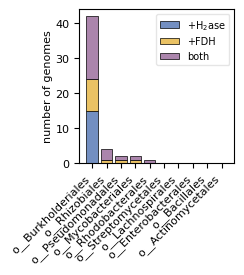

In [ ]:
plt.figure(figsize=(2, 2))

# stacked bar values are along the rows below
bar_vals = ct.values

# plot the stacked bar chart
xs = np.arange(len(ct.index))
plt.bar(xs, bar_vals[:, 0], color=lin_colors[1], edgecolor='k', lw=0.5)
plt.bar(xs, bar_vals[:, 1], bottom=bar_vals[:, 0], color=lin_colors[2], edgecolor='k', lw=0.5)
plt.bar(xs, bar_vals[:, 2], bottom=bar_vals[:, 0]+bar_vals[:, 1], color=lin_colors[3], edgecolor='k', lw=0.5)

# relabel legend
plt.legend(['+H$_2$ase', '+FDH', 'both'], loc=1, framealpha=0.5)

my_xticks = ct.index.values
print(my_xticks)
# find PCC-6307, replace with its only family Cyanobiaceae
my_xticks[my_xticks == 'PCC-6307'] = 'Cyanobiaceae'

tick_pos = np.arange(0, len(my_xticks), 1)
plt.xticks(tick_pos, my_xticks, rotation=45, ha='right')
plt.ylabel('number of genomes')
#plt.ylim(0, 50)
plt.xlabel('')
plt.savefig('../output/plots/top_hits_by_order_small.pdf', bbox_inches='tight')
plt.savefig('../output/plots/top_hits_by_order_small.png', bbox_inches='tight')

plt.show()

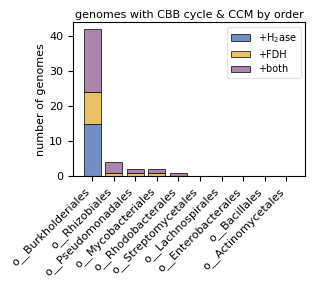

In [ ]:
plt.figure(figsize=(3, 2))

# stacked bar values are along the rows below
bar_vals = ct.values

# plot the stacked bar chart
xs = np.arange(len(ct.index))
bottom = np.zeros(len(ct.index))
for i in range(bar_vals.shape[1]):
    plt.bar(xs, bar_vals[:, i], bottom=bottom, color=lin_colors[i+1],
            edgecolor='k', lw=0.5)
    bottom += bar_vals[:, i]

plt.legend(['+H$_2$ase', '+FDH', '+both'], loc=1, framealpha=0.5)

my_xticks = ct.index.values
# find PCC-6307, replace with its only family Cyanobiaceae
my_xticks[my_xticks == 'PCC-6307'] = 'Cyanobiaceae'

tick_pos = np.arange(0, len(my_xticks), 1)
plt.xticks(tick_pos, my_xticks, rotation=45, ha='right')
plt.title('genomes with CBB cycle & CCM by order')
plt.ylabel('number of genomes')
plt.xlabel('')
plt.savefig('../output/plots/next_steps_plots/genomes with CBB cycle & CCM by order.pdf', bbox_inches='tight')

plt.show()

In [ ]:
bar_vals

array([[15,  9, 18],
       [ 0,  1,  3],
       [ 0,  1,  1],
       [ 0,  1,  1],
       [ 0,  0,  1],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0]])

In [ ]:
cols = ['rubisco_csome', 'fdh', 'h2ase', 'n2ase']
ct = pd.crosstab(for_plotting['gtdb_order'], [for_plotting[c] for c in cols],
                 rownames=['gtdb_order'],
                 colnames=cols)
ct_vals = ct.values[:,1:]
sums = ct_vals.sum(axis=1)

# reorder by sums, neglecting rubisco_csome alone
order = np.argsort(sums)[::-1]
ct = ct.iloc[order]
ct

rubisco_csome       False                                           True   \
fdh                 False                   True                    False   
h2ase               False       True        False       True        False   
n2ase               False True  False True  False True  False True  False   
gtdb_order                                                                  
o__Burkholderiales     34     3    49    10   965    44   197   113     7   
o__Pseudomonadales      7     2    13     1  1115    20    88    25     1   
o__Rhizobiales         47     0     1     8   697   159    74   173     4   
o__Enterobacterales     1     5     8     4   684    36   322    39     0   
o__Mycobacteriales      9     0    17     1   606     0   428    13     0   
o__Lachnospirales      13    19   483    88    22     0   139    24     0   
o__Actinomycetales    211     1     4     0   674     0    54     0     0   
o__Rhodobacterales     17     0     4     1   583     8    93    32     0   
o__Bacillales          15     4   120     0   307     2   229     1     0   
o__Streptomycetales     0     0     2     0   269     0   366     0     0   

rubisco_csome                                      
fdh                             True               
h2ase               True        False True         
n2ase               False True  False False True   
gtdb_order                                         
o__Burkholderiales     11     4     9    11     7  
o__Pseudomonadales      0     0     1     1     0  
o__Rhizobiales          0     0     1     0     3  
o__Enterobacterales     0     0     0     0     0  
o__Mycobacteriales      0     0     1     1     0  
o__Lachnospirales       0     0     0     0     0  
o__Actinomycetales      0     0     0     0     0  
o__Rhodobacterales      0     0     0     1     0  
o__Bacillales           0     0     0     0     0  
o__Streptomycetales     0     0     0     0     0

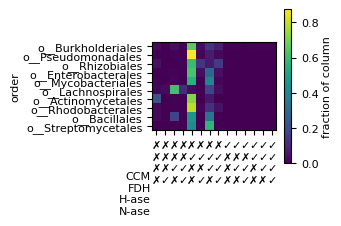

In [ ]:
# make a heatmap from the above contingency table
plt.figure(figsize=(2, 2))

# Normalize counts per-column
norm_ct = ct.div(ct.sum(axis=1), axis=0)
plt.imshow(norm_ct.values, cmap='viridis')
cb = plt.colorbar(label='fraction of column')

my_yticks = norm_ct.index.values
# find PCC-6307, replace with its only family Cyanobiaceae
my_yticks[my_xticks == 'PCC-6307'] = 'Cyanobiaceae'
plt.yticks(np.arange(len(norm_ct.index)), my_yticks, rotation=0)

# use unicode check to represent TRUE and unicode X to represent false 
subs = lambda x: "\u2713" if x else "\u2717"
my_xticks = ['\n'.join(map(subs, c)) for c in norm_ct.columns.values]

plt.xticks(np.arange(len(norm_ct.columns)), my_xticks, ha='center')

contingency_table_label = '\n'.join('CCM,FDH,H-ase,N-ase'.split(','))
plt.figtext(0.12, 0.07, contingency_table_label, va='top', ha='right', size=8)

plt.ylabel('order')
#plt.xlabel('')
plt.savefig('../output/plots/top_hits_by_order_heatmap.pdf', bbox_inches='tight')
plt.show()

In [ ]:
norm_ct.columns

MultiIndex([(False, False, False, False),
            (False, False, False,  True),
            (False, False,  True, False),
            (False, False,  True,  True),
            (False,  True, False, False),
            (False,  True, False,  True),
            (False,  True,  True, False),
            (False,  True,  True,  True),
            ( True, False, False, False),
            ( True, False,  True, False),
            ( True, False,  True,  True),
            ( True,  True, False, False),
            ( True,  True,  True, False),
            ( True,  True,  True,  True)],
           names=['rubisco_csome', 'fdh', 'h2ase', 'n2ase'])